In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


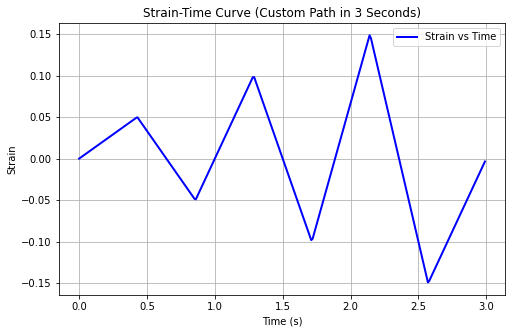

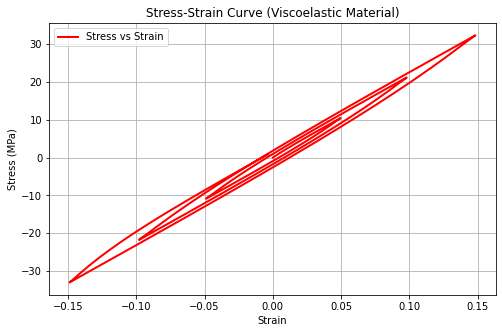

In [6]:
# Parameters for the viscoelastic model
A = 200  # Elastic stiffness matrix in MPa
Q = 10   # Kernel decay rate
D = 50   # Damping coefficient in MPa·s
dt = 0.01  # Time step

# Time array
total_time = 3  # Total time for custom strain path (3 seconds)
time = np.arange(0, total_time, dt)  # Time array

# Define custom strain points and corresponding time points
custom_strain_points = [0, 0.05, -0.05, 0.1, -0.1, 0.15, -0.15, 0]
custom_time_points = np.linspace(0, total_time, len(custom_strain_points))

# Interpolate to create the strain path
strain = np.interp(time, custom_time_points, custom_strain_points)

# Strain rate (dE/dt) using numerical differentiation
strain_rate = np.gradient(strain, dt)

# Initialize stress array for storing computed stress values
stress = np.zeros_like(time)

# Compute stress using the convolution integral
for i in range(1, len(time)):
    # Elastic stress component
    elastic_stress = A * strain[i]
    
    # Viscoelastic stress component
    viscoelastic_stress = 0
    for j in range(i):
        kernel = np.exp(-Q * (time[i] - time[j]))  # Decaying kernel
        viscoelastic_stress += kernel * D * strain_rate[j] * dt  # Convolution for viscoelastic contribution
    
    # Total stress is the sum of elastic and viscoelastic components
    stress[i] = elastic_stress + viscoelastic_stress

# Plot the strain-time curve
plt.figure(figsize=(8, 5))
plt.plot(time, strain, label="Strain vs Time", color='b', linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("Strain-Time Curve (Custom Path in 3 Seconds)")
plt.grid(True)
plt.legend()
plt.show()

# Plot the stress-strain curve
plt.figure(figsize=(8, 5))
plt.plot(strain, stress, label="Stress vs Strain", color='r', linewidth=2)
plt.xlabel("Strain")
plt.ylabel("Stress (MPa)")
plt.title("Stress-Strain Curve (Viscoelastic Material)")
plt.grid(True)
plt.legend()
plt.show()

# Convert to torch tensors for training
strain_tensor = torch.tensor(strain, dtype=torch.float32).unsqueeze(1)  # Shape (N, 1)
stress_tensor = torch.tensor(stress, dtype=torch.float32).unsqueeze(1)  # Shape (N, 1)

# Create dataset and dataloader
dataset = TensorDataset(strain_tensor, stress_tensor)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [12]:
class PotentialW(nn.Module):
    def __init__(self):
        super(PotentialW, self).__init__()
        # Define the neural network layers for learning W (N_theta)
        self.fc = nn.Sequential(
            nn.Linear(1, 64),  # Input: strain (E)
            nn.Softplus(),
            nn.Linear(64, 64),
            nn.Softplus(),
            nn.Linear(64, 1)
        )
    
    def forward(self, strain):
        # Compute the neural network output N_theta(E)
        N_theta = self.fc(strain)
        
        # Compute the gradient of N_theta with respect to strain at E = 0
        # This is necessary to enforce consistency
        strain_zero = torch.zeros_like(strain)  # Zero strain for consistency condition
        N_theta_grad_at_zero = torch.autograd.functional.jacobian(lambda x: self.fc(x), strain_zero).squeeze()
        
        # Implement W(E) = N_theta(E) - N_theta_grad_at_zero * E
        W_theta = N_theta - N_theta_grad_at_zero * strain
        
        return W_theta


In [15]:
class PotentialW(nn.Module):
    def __init__(self):
        super(PotentialW, self).__init__()
        # Define the neural network layers for learning W (N_theta)
        self.fc = nn.Sequential(
            nn.Linear(1, 64),  # Input: strain (E)
            nn.Softplus(),
            nn.Linear(64, 64),
            nn.Softplus(),
            nn.Linear(64, 1)
        )
    
    def forward(self, strain):
        # Compute the neural network output N_theta(E)
        N_theta = self.fc(strain)
        
        # Compute the gradient of N_theta with respect to strain at E = 0
        # This is necessary to enforce consistency
        strain_zero = torch.zeros_like(strain)  # Zero strain for consistency condition
        N_theta_grad_at_zero = torch.autograd.functional.jacobian(lambda x: self.fc(x), strain_zero).squeeze()
        
        # Implement W(E) = N_theta(E) - N_theta_grad_at_zero * E
        W_theta = N_theta - N_theta_grad_at_zero * strain
        
        return W_theta


In [16]:
class PotentialV(nn.Module):
    def __init__(self):
        super(PotentialV, self).__init__()
        # Define the neural network layers for learning V (M_Phi)
        self.fc = nn.Sequential(
            nn.Linear(1, 64),  # Input will be delta = C1 * E + C2 * alpha
            nn.Softplus(),
            nn.Linear(64, 64),
            nn.Softplus(),
            nn.Linear(64, 1)
        )
        # Initialize C1 and C2 as learnable parameters (4th-order tensors)
        self.C1 = nn.Parameter(torch.tensor([1.0]), requires_grad=True)
        self.C2 = nn.Parameter(torch.tensor([1.0]), requires_grad=True)
    
    def forward(self, strain, alpha):
        # Compute delta = C1 * E + C2 * alpha
        delta = self.C1 * strain + self.C2 * alpha
        
        # Compute the neural network output M_Phi(delta)
        M_Phi = self.fc(delta)
        
        # Compute the gradient of M_Phi with respect to delta at delta = 0
        delta_zero = torch.zeros_like(delta)  # Zero delta for consistency condition
        M_Phi_grad_at_zero = torch.autograd.functional.jacobian(lambda x: self.fc(x), delta_zero).squeeze()
        
        # Implement V(E, alpha) = M_Phi(delta) - M_Phi_grad_at_zero * delta
        V_Phi = M_Phi - M_Phi_grad_at_zero * delta
        
        return V_Phi


In [17]:
class PotentialG(nn.Module):
    def __init__(self):
        super(PotentialG, self).__init__()
        # Define the neural network layers for learning G (D_r)
        self.fc = nn.Sequential(
            nn.Linear(1, 64),  # Input: beta (internal stress)
            nn.Softplus(),
            nn.Linear(64, 64),
            nn.Softplus(),
            nn.Linear(64, 1)
        )
    
    def forward(self, beta, strain):
        # Compute the neural network output D_r(beta, E)
        D_r = self.fc(beta)
        
        # Compute the gradient of D_r with respect to beta at beta = 0
        beta_zero = torch.zeros_like(beta)  # Zero beta for consistency condition
        D_r_grad_at_zero = torch.autograd.functional.jacobian(lambda x: self.fc(x), beta_zero).squeeze()
        
        # Implement G(beta, E) = D_r(beta, E) - D_r_grad_at_zero * beta
        G_sigma = D_r - D_r_grad_at_zero * beta
        
        return G_sigma


NameError: name 'nn' is not defined

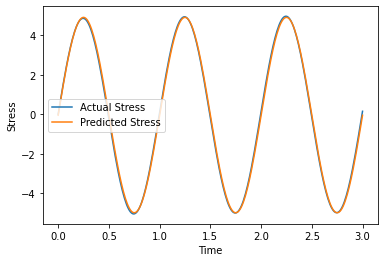